<a href="https://colab.research.google.com/github/Sushila-Phogat/CE888/blob/master/Lab8/Flowers_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "sushilakumari" # username from the json file
os.environ['KAGGLE_KEY'] = "87aa4a19a3b29f38f457fd53233688e6" # key from the json file
!kaggle datasets download -d alxmamaev/flowers-recognition # api copied from kaggle

 98% 439M/450M [00:02<00:00, 199MB/s]
100% 450M/450M [00:02<00:00, 177MB/s]


In [3]:
!git clone https://github.com/sagihaider/CE888_2020.git

Cloning into 'CE888_2020'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 25162 (delta 36), reused 4 (delta 0), pack-reused 25082
Receiving objects: 100% (25162/25162), 562.19 MiB | 51.31 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [5]:
# Upload data
from zipfile import ZipFile
file_name = "/content/flowers-recognition.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')


done


In [0]:
import shutil
shutil.rmtree('/content/flowers/flowers')

In [7]:
!pip install tensorflow==1.3.0
!pip install keras==2.0.7

     |████████████████████████████████| 43.6MB 95kB/s 
     |████████████████████████████████| 1.6MB 43.5MB/s 
     |████████████████████████████████| 890kB 56.7MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=36621736c7118de0a9051a8e5ba8c829bd1c5218f30afdf0fa405fb1dc5cb892
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.3
    Uninstalling bleach-3.1.3:
      Successfully uninstalled bleach-3.1.3
  Found existing installation: tensorflow 2.2.0rc1
    Uninstalling tensorflow-2.2.0rc1:
      Successfully uninstalled tensorflow-2.2.0rc1
     |████████████████████████████████| 276kB 2.8MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.7 which is incompat

In [8]:
import numpy as np
import os
import time
from CE888_2020.Lab_8.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarn

In [9]:
#Loading the training data
import os
import sys
import shutil
PATH = os.getcwd()
# Define data path
data_path = PATH + '/flowers'
data_dir_list = os.listdir(data_path)
img_data_list=[]
print(data_dir_list)

for dataset in data_dir_list:
  img_list=os.listdir(data_path+'/'+ dataset)
  print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
  for img in img_list:
    if img.endswith('.jpg'):
      img_path = data_path + '/'+ dataset + '/'+ img
      img = image.load_img(img_path, target_size=(224, 224))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
#		x = x/255
		# print('Input image shape:', x.shape)
      img_data_list.append(x)

#%% 
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

['daisy', 'sunflower', 'tulip', 'dandelion', 'rose']
Loaded the images of dataset-daisy

Loaded the images of dataset-sunflower

Loaded the images of dataset-tulip

Loaded the images of dataset-dandelion

Loaded the images of dataset-rose

(4323, 1, 224, 224, 3)
(1, 4323, 224, 224, 3)
(4323, 224, 224, 3)


In [10]:
# Define the number of classes
num_classes = 5
num_of_samples = img_data.shape[0]
print(num_of_samples)
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:202]=0
labels[202:404]=1
labels[404:606]=2
labels[606:808]=3
labels[808:]=3

names = ['daisy', 'sunflower', 'tulip', 'dandelion', 'rose']

# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

4323


In [11]:
#%% Fine Tuning

image_input = Input(shape=(224, 224, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

model.summary()

549273600/553467096 [============================>.] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (M

In [12]:
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_vgg_model2 = Model(image_input, out)
custom_vgg_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
# freeze all the layers except the dense layers
for layer in custom_vgg_model2.layers[:-3]:
	layer.trainable = False

custom_vgg_model2.summary()

custom_vgg_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
t=time.time()
#	t = now()
hist = custom_vgg_model2.fit(X_train, y_train, batch_size=32, epochs=4, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Train on 3458 samples, validate on 865 samples
Epoch 1/4
3458/3458 [==============================] - 3713s - loss: 1.2860 - acc: 0.8372 - val_loss: 0.7504 - val_acc: 0.8197
Epoch 2/4
3458/3458 [==============================] - 3699s - loss: 0.4155 - acc: 0.9069 - val_loss: 0.7324 - val_acc: 0.8324
Epoch 3/4
3458/3458 [==============================] - 3676s - loss: 0.2075 - acc: 0.9534 - val_loss: 0.9232 - val_acc: 0.8428
Epoch 4/4
3458/3458 [==============================] - 3681s - loss: 0.1261 - acc: 0.9780 - val_loss: 0.8641 - val_acc: 0.8347
Training time: -14771.3681640625
865/865 [==============================] - 732s   
[INFO] loss=0.8641, accuracy: 83.4682%


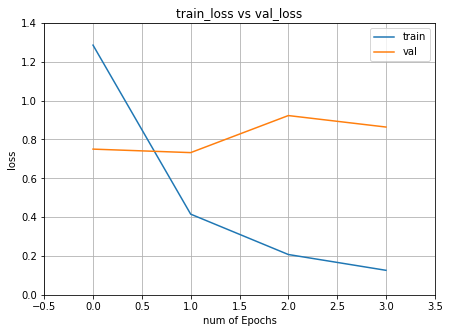

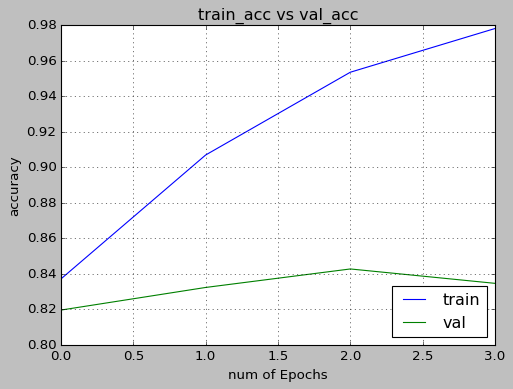

In [15]:
#%% plot
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(4)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])